# AMPLPY: Pattern Enumeration

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/amplpy/blob/master/notebooks/pattern_enumeration.ipynb)

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/amplpy/blob/master/notebooks/pattern_enumeration.ipynb)

Documentation: http://amplpy.readthedocs.io

GitHub Repository: https://github.com/ampl/amplpy

PyPI Repository: https://pypi.python.org/pypi/amplpy

Jupyter Notebooks: https://github.com/ampl/amplpy/tree/master/notebooks

### Setup

In [1]:
!pip install -q amplpy ampltools amplpy matplotlib numpy

### Google Colab & Kaggle interagration

In [2]:
import os
RUNNING_IN_GOOGLE_COLAB = 'COLAB_GPU' in os.environ
RUNNING_IN_KAGGLE = os.path.abspath(os.curdir).startswith('/kaggle/')
RUNNING_IN_THE_CLOUD = RUNNING_IN_GOOGLE_COLAB or RUNNING_IN_KAGGLE

In [3]:
# If you have an AMPL Cloud License or an AMPL CE license, you can use it on Google Colab and similar platforms.
# Note: Your license UUID should never be shared. Please make sure you delete the license UUID
# and rerun this cell before sharing the notebook with anyone.
LICENSE_UUID = None
# You can install individual modules from https://portal.ampl.com/dl/modules/
MODULES = ['ampl', 'gurobi']
# Set to True in order to install AMPL only once 
RUN_ONCE = True
if RUNNING_IN_THE_CLOUD:
    from ampltools import ampl_installer
    ampl_dir = os.path.abspath(os.path.join(os.curdir, 'ampl.linux-intel64'))
    ampl_installer(modules=MODULES, license_uuid=LICENSE_UUID, run_once=RUN_ONCE, verbose=True)
    os.environ['PATH'] += os.pathsep + ampl_dir

### Import and instantiate

In [4]:
from amplpy import AMPL, register_magics
ampl = AMPL()
ampl.eval('option version;')
# Store %%ampl cells in the list _ampl_cells
# Evaluate %%ampl_eval cells with ampl.eval()
register_magics(store_name='_ampl_cells', ampl_object=ampl)

option version 'AMPL Version 20220119 (Darwin-19.6.0, 64-bit)\
Demo license with maintenance expiring 20240131.\
Using license file "/Users/fdabrandao/bin/ampl.macos64/ampl.lic".\
';


### Basic pattern-cutting model

In [5]:
%%ampl_eval
param nPatterns integer > 0;
set PATTERNS = 1..nPatterns; # patterns
set WIDTHS; # finished widths
param order {WIDTHS} >= 0; # rolls of width j ordered
param overrun; # permitted overrun on any width
param rolls {WIDTHS,PATTERNS} >= 0 default 0; # rolls of width i in pattern j

var Cut {PATTERNS} integer >= 0; # raw rolls to cut in each pattern

minimize TotalRawRolls: sum {p in PATTERNS} Cut[p];

subject to FinishedRollLimits {w in WIDTHS}:
  order[w] <= sum {p in PATTERNS} rolls[w,p] * Cut[p] <= order[w] + overrun;

### Enumeration routine

In [6]:
from math import floor

def patternEnum(roll_width, widths, prefix=[]):
    max_rep = int(floor(roll_width/widths[0]))
    if len(widths) == 1:
        patmat = [prefix+[max_rep]]
    else:
        patmat = []
        for n in reversed(range(max_rep+1)):
            patmat += patternEnum(roll_width-n*widths[0], widths[1:], prefix+[n])
    return patmat

### Plotting routine

In [7]:
def cuttingPlot(roll_width, widths, solution):
    import numpy as np
    import matplotlib.pyplot as plt
    ind = np.arange(len(solution))
    acc = [0]*len(solution)
    for p, (patt, rep) in enumerate(solution):
        for i in range(len(widths)):
            for j in range(patt[i]):
                vec = [0]*len(solution)
                vec[p] = widths[i]
                plt.bar(ind, vec, width=0.35, bottom=acc)
                acc[p] += widths[i]
    plt.title('Solution')
    plt.xticks(ind, tuple("x {:}".format(rep) for patt, rep in solution))
    plt.yticks(np.arange(0, roll_width, 10))
    plt.show()

### Set & generate data

In [8]:
roll_width = 64.5
overrun = 6
orders = {
    6.77: 10,
    7.56: 40,
    17.46: 33,
    18.76: 10
}
widths = list(sorted(orders.keys(), reverse=True))
patmat = patternEnum(roll_width, widths)

### Send data to AMPL (Java/C++ style)

In [9]:
# Send scalar values
ampl.getParameter('overrun').set(overrun)
ampl.getParameter('nPatterns').set(len(patmat))
# Send order vector
ampl.getSet('WIDTHS').setValues(widths)
ampl.getParameter('order').setValues(orders)
# Send pattern matrix
ampl.getParameter('rolls').setValues({
    (widths[i], 1+p): patmat[p][i]
    for i in range(len(widths))
    for p in range(len(patmat))
})

### Send data to AMPL (alternative style)

In [10]:
# Send scalar values
ampl.param['overrun'] = overrun
ampl.param['nPatterns'] = len(patmat)
# Send order vector
ampl.set['WIDTHS'] = widths
ampl.param['order'] = orders
# Send pattern matrixc 
ampl.param['rolls'] = {
    (widths[i], 1+p): patmat[p][i]
    for i in range(len(widths))
    for p in range(len(patmat))
}

### Solve and report

gurobi (Darwin x86_64), licchk(20131021), ASL(20211109)
Gurobi 9.5.0: optimal solution; objective 18
6 simplex iterations
1 branch-and-cut nodes


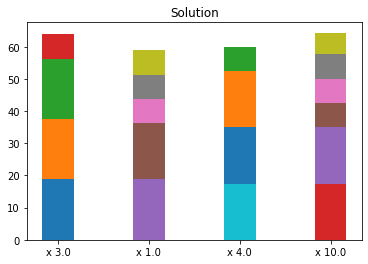

In [11]:
# Solve
ampl.option['solver'] = 'gurobi'
ampl.solve()
# Retrieve solution
cutting_plan = ampl.var['Cut'].getValues()
cutvec = list(cutting_plan.getColumn('Cut.val'))

# Display solution
solution = [
    (patmat[p], cutvec[p])
    for p in range(len(patmat))
    if cutvec[p] > 0
]
cuttingPlot(roll_width, widths, solution)